* Modélisation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
data = pd.read_csv("df_final.csv")
data.shape

/tmp/ipykernel_3303/1621852662.py:1: DtypeWarning: Columns (1,19,20,21,22,34,39,40,41,42,43,49,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("df_final.csv")


(5017137, 54)

In [6]:
df = data.copy()

Isolation des variables météorologiques ayant un effet sur la variable incendie (isolées précédemment).
Création de la matrice de design X et la taget y.

In [33]:
df_prediction = df[['dd','ff','t','td','precip','hu', 'incendie']]
print(df_prediction.shape)
df_prediction = df_prediction.dropna()
print(df_prediction.shape)
X = df_prediction[['dd','ff','t','td','precip','hu']]
y = df_prediction['incendie']
y.sum()

(5017137, 7)
(2019491, 7)


898

Le nombre de variables explicatives étant faible, il est possible de ne garder que les lignes sans NaN en gardant largement suffisamment de données (2 millions de données dont 898 incendies)

Séparation de la base en données de test et d'entraînement

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Créer et entraîner le modèle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Création du modèle de régression logistique. Le pre-processing est un Standard Scaler permettant de standardiser les données. L'option class_weight = 'balanced' permet de pondérer les classes et ainsi de prendre en compte la sous-représentation de la classes incendie dans les données par rapport à la classe "pas d'incendie". En effet, sans cette option, le modèle renvoie toujours 0 car il a alors une excellente accuracy bien qu'il n'ait rien appris.

In [77]:
model = Pipeline([('scaler',StandardScaler()),
                      ('classi',LogisticRegression(class_weight='balanced'))]
                )
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classi', LogisticRegression(class_weight='balanced'))])

Prédiction du fait qu'il y ait un incendie sur les données météo de test

In [78]:
ypred = model.predict(X_test)
print(confusion_matrix(y_test, ypred))

[[283299 120424]
 [    43    133]]


La confusion matrix permet de regarder en détail comment ont été classées les données de test par le modèles. Sur les données sans incendies, environ 280 000 ont été bien classifiées contre 120 000 mal classifiées. Sur les données avec incendie, 133 ont été bien classifiées contre 43 mal classifiées. Le modèle a réussi a reconnaître des conditions météo propices aux incendies. La classification ne peut de toute façon pas être excellente car la météo ne détermine pas totalement le fait qu'il y ait un incendie (par exemple, un même jour il y aura les mêmes conditions météo dans deux communes mais un incendie ne va se déclarer que dans l'une des deux).

On regarde désormais plus en détail les probabilités d'incendie trouvées par le modèle.

In [79]:
proba0 = model.predict_proba(X_test[y_test==0])
proba1 = model.predict_proba(X_test[y_test==1])

On compare la distribution des probalitités d'incendie prédites par le modèle sur les données pour lesquelles il n'y avait pas d'incendie avec la distribution des probalitités d'incendie prédites par le modèle sur les données pour lesquelles il y a eu un incendie.

/tmp/ipykernel_3303/2809409026.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(proba0[:,1], color='blue', label="pas d'incendie")
/tmp/ipykernel_3303/2809409026.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(proba1[:,1], color='red', label="incendie")


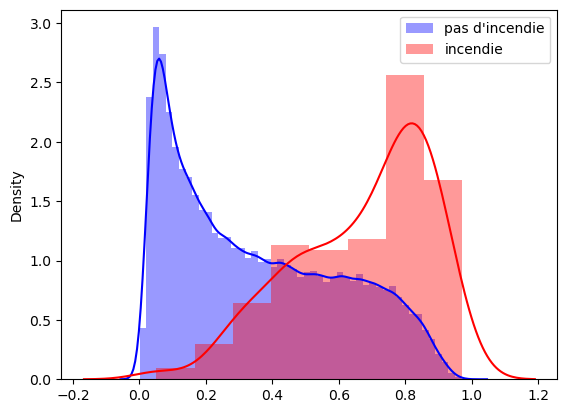

In [137]:
plt.figure()
sns.distplot(proba0[:,1], color='blue', label="pas d'incendie")
sns.distplot(proba1[:,1], color='red', label="incendie")
plt.legend()
plt.show()

On remarque que même si beaucoup de données sont mal classifiées, le modèle donne bien des probabilités d'incendie plus élevées lorsqu'il y a eu un incendie.

Le modèle réussit alors à capter des influences des variables météorologiques sur le risque d'incendie

Etudions maintenant les coefficients de la régression logistique

In [85]:
coeffs = pd.DataFrame(data= model.named_steps['classi'].coef_, columns = X.columns, index=['coefficient'])
coeffs

,dd,ff,t,td,precip,hu
coefficient,0.023002,0.250419,-1.105582,1.515885,0.081197,-1.753249


Les coefficients peuvent être comparés entre eux grâce à la standardisation des données. Plus la valeur absolue du coefficient est grande, plus la variable influe sur la probabilité d'être classifié en incendie. Un signe positif (resp. négatif) indique une relation croissante (resp. décroissante) entre la variable et le risque d'incendie.

Les variables les plus importantes semblent êtres l'humidité (hu) et les variables de température (t, td).

Notons un point surprenant : le coefficient associé à la température moyenne sur la journée (t) est négatif alors que cette variable est corrélée positivement à la variable incendie comme vu précédemment. Ceci est du au fait que la corrélation de t et td est de 0.9 donc il y a un effet de compensation entre le coefficient positif de td et le coefficient négatif de t. Pour avoir un modèle causal, il faudrait peut-être supprimer l'une des deux variables.

* Essai d'un autre modèle prédictif : AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = Pipeline([('scaler',StandardScaler()),
                      ('classi',AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    n_estimators=10,
    algorithm="SAMME.R",
    learning_rate=0.1,
    random_state=42
))]
                     )
ada.fit(X_train, y_train)

proba0_ada = ada.predict_proba(X_test[y_test==0])
proba1_ada = ada.predict_proba(X_test[y_test==1])

ypred_ada = ada.predict(X_test)

In [140]:
print("matrice de confusion du nouveau modèle :")
print(confusion_matrix(y_test, ypred_ada))
print("matrice de confusion de la régression logistique :")
print(confusion_matrix(y_test, ypred))

matrice de confusion du nouveau modèle :
[[266856 136867]
 [    28    148]]
matrice de confusion de la régression logistique :
[[283299 120424]
 [    43    133]]


Ce nouveau modèle classe mieux les données avec incendie mais moins bien celles sans incendie.

In [141]:
probabilities = model.predict_proba(X_test)
probabilities_ada = ada.predict_proba(X_test)

auc_roc = roc_auc_score(y_test, probabilities[:, 1])
auc_roc_ada =  roc_auc_score(y_test, probabilities_ada[:, 1])

print(f'AUC-ROC de la régression logistique: {auc_roc}')
print(f'AUC-ROC de AdaBoost: {auc_roc_ada}')

AUC-ROC de la régression logistique: 0.8285520726069382
AUC-ROC de AdaBoost: 0.8264087333844785


Les deux modèles obtiennent des scores auc-roc assez similaires, au sens de cette métrique ces deux modèles sont aussi bons classifiers.

/tmp/ipykernel_3303/4007782794.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(proba0_ada[:,1], color='blue', label="pas d'incendie")
/tmp/ipykernel_3303/4007782794.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(proba1_ada[:,1], color='red', label="incendie")


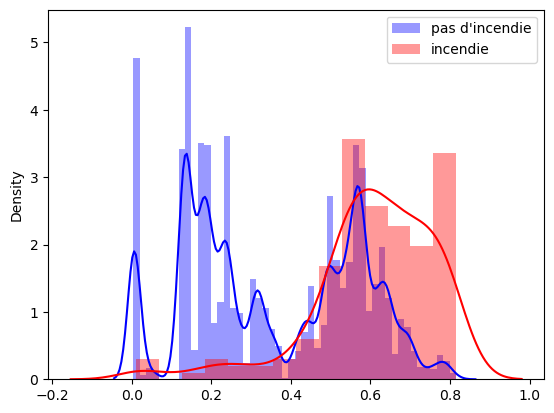

In [142]:
plt.figure()
sns.distplot(proba0_ada[:,1], color='blue', label="pas d'incendie")
sns.distplot(proba1_ada[:,1], color='red', label="incendie")
plt.legend()
plt.show()

Les distributions de probabilités prédites sont différentes de celles de la régression logistique. On remarque qu'un pic de la distribution bleue correspond avec le pic de la distribution rouge. Cela correspond peut-être au fait que pour des mêmes conditions météo, il peut y avoir un incendie à un endroit et pas à un autre.

Le modèle AdaBoost basé sur des arbres de décisions a pour avantage de donner l'importance relatives des features dans la prédiction, ce qui est un équivalent des coefficients de la régression logistique, même si l'importance de la variable ne dit rien sur la nature de sa relation avec le risque d'incendie

In [143]:
importances = pd.DataFrame(data= ada.named_steps['classi'].feature_importances_.reshape(1,6), columns = X.columns, index=['importance'])
importances

,dd,ff,t,td,precip,hu
importance,0.017271,0.074997,0.282401,0.005173,0.007443,0.612715


On remarque que deux variables météo se démarquent en terme d'importance : en premier lieu l'humidité (plus de 60%), puis la température moyenne sur la journée (t).